In [9]:
import os
import sys

# Go one level up to access the project root
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)                   # adds the project root
sys.path.append(os.path.join(project_root, "models"))  # adds models folder

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

from dataset import BrainTumorDataset
from resnet import ResNetClassifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "resnet_brain_tumor_classifier.pth"

model = ResNetClassifier(num_classes=4)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

print(f"Model loaded successfully from {model_path}")


Model loaded successfully from resnet_brain_tumor_classifier.pth


In [17]:
DATA_ROOT = "../data"
test_root_dir = os.path.join(DATA_ROOT, "Testing")
MODEL_PATH = "resnet_brain_tumor_classifier.pth"
NUM_CLASSES = 4

# Transforms (same as in training)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = BrainTumorDataset(root_dir=test_root_dir, transform=image_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class_names = [test_dataset.idx_to_class[i] for i in sorted(test_dataset.idx_to_class.keys())]
print(f"Found {len(test_dataset)} test images across {len(class_names)} classes.")


Class to index mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Found 394 test images across 4 classes.


In [18]:
model = ResNetClassifier(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded successfully.")


Model loaded successfully.


In [19]:
y_true, y_pred = [], []

with torch.no_grad():
    for data in test_loader:
        images = data['image'].to(device)
        labels = data['label'].to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Evaluation complete.")


Evaluation complete.


In [21]:
from sklearn.metrics import classification_report, accuracy_score

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
accuracy = accuracy_score(y_true, y_pred)

print("\n--- CNN Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))
print(f"\n Accuracy: {accuracy * 100:.2f}%")



--- CNN Classification Report ---
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.37      0.54       100
meningioma_tumor       0.78      0.95      0.85       115
        no_tumor       0.70      1.00      0.82       105
 pituitary_tumor       0.98      0.88      0.93        74

        accuracy                           0.80       394
       macro avg       0.86      0.80      0.79       394
    weighted avg       0.85      0.80      0.78       394


 Accuracy: 80.20%



--- CNN Confusion Matrix ---


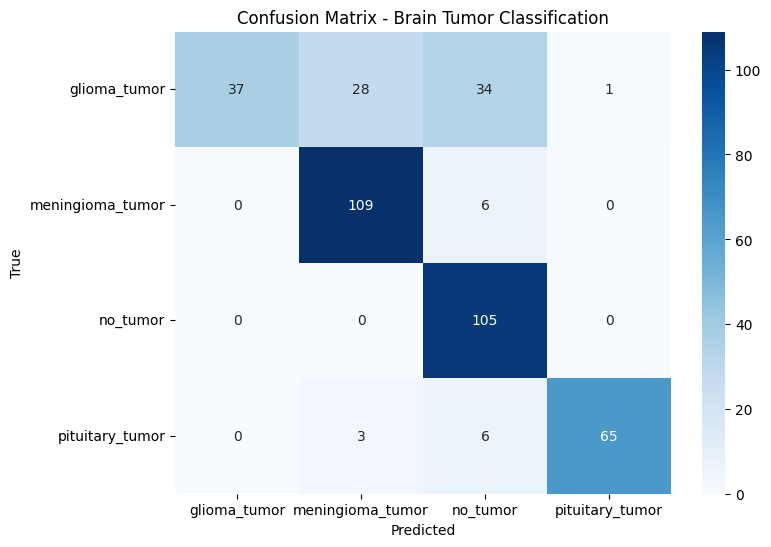

In [ ]:
print("\n--- CNN Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Brain Tumor Classification')
plt.show()

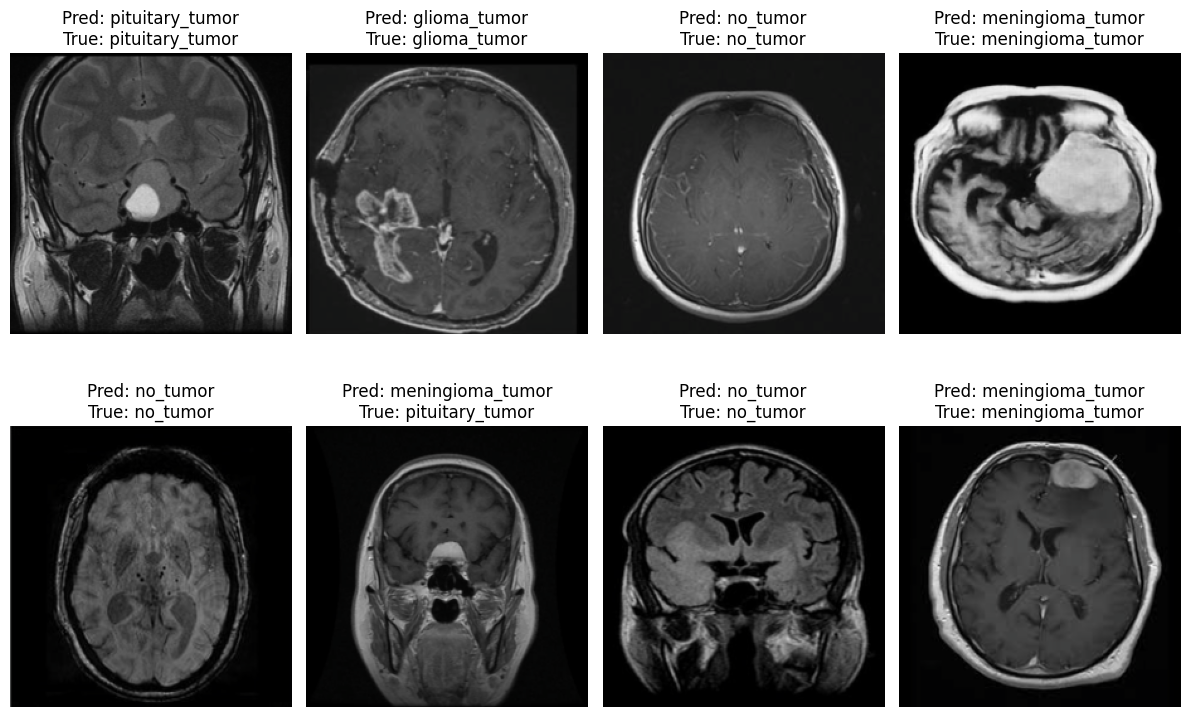

: 

In [ ]:
# Show some sample predictions
sample_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
sample_batch = next(iter(sample_loader))
images, labels = sample_batch['image'].to(device), sample_batch['label'].to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
